In [ ]:
import imutils
from imutils import perspective, contours
import numpy as np
import cv2
import matplotlib.pyplot as plt
from glob import glob
from google.colab.patches import cv2_imshow
import statistics as stats

In [ ]:
# mask_files = sorted(glob("/content/drive/MyDrive/Rocks/train_mask_256/*.jpg"))
# image_files = sorted(glob("/content/drive/MyDrive/Rocks/train_resized_256/*.jpg"))

mask_files = sorted(glob("/content/drive/MyDrive/Rocks/Data_n_Masks/all_data_masks/*.tiff"))
image_files = sorted(glob("/content/drive/MyDrive/Rocks/Data_n_Masks/all_data_original/*.jpg"))

# 0 - scale, 1 - sandstone, 2 - mudstone
mask_files = sorted(list(filter(lambda x : not x.endswith(' (1).tiff'), mask_files)))
image_files = sorted(list(filter(lambda x : not x.endswith(' (1).jpg'), image_files)))
len(image_files), len(mask_files)

(102, 102)

96
(256, 256, 3) (800, 1200)


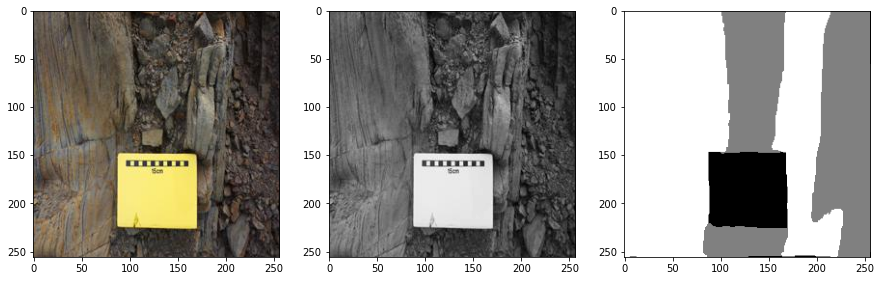

In [ ]:
# i = 10
i = np.random.randint(102)
print(i)
sample_img = cv2.imread(image_files[i])
sample_mask = cv2.imread(mask_files[i], 0)

# root = "/content/drive/MyDrive/Rocks/Data_n_Masks/"
# sample_img_path = root + "all_data_original/" + "4.jpg"
# sample_mask_path = root + "all_data_masks/" + "4.tiff"
# sample_img = cv2.imread(sample_img_path)
# sample_mask = cv2.imread(sample_mask_path, 0)

print(sample_img.shape, sample_mask.shape)
if sample_img.shape[:2] != (256, 256):
    sample_img = cv2.resize(sample_img, (256, 256), interpolation=cv2.INTER_AREA)
if sample_mask.shape != sample_img.shape[:2]:
    sample_mask = cv2.resize(sample_mask, sample_img.shape[:2], interpolation=cv2.INTER_AREA)
sample_img_gray = cv2.cvtColor(sample_img, cv2.COLOR_BGR2GRAY)
fig, axes = plt.subplots(1, 3, figsize=(15, 10))
axes[0].imshow(cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB))
axes[1].imshow(sample_img_gray, cmap='gray')
axes[2].imshow(sample_mask, cmap='gray')

### Visualize

(4000, 6000, 3) (4000, 6000)
(256, 256, 3) (800, 1200)
(4000, 6000, 3) (4000, 6000)
(4000, 6000, 3) (4000, 6000)
(256, 256, 3) (800, 1200)


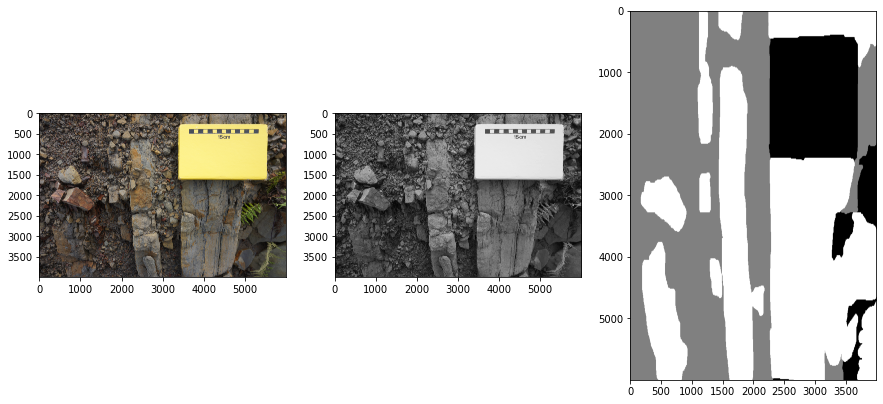

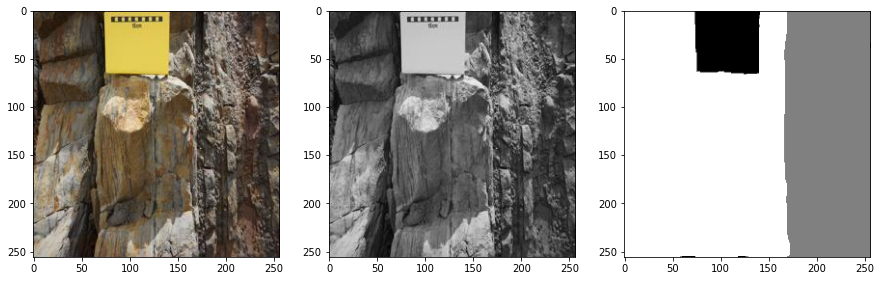

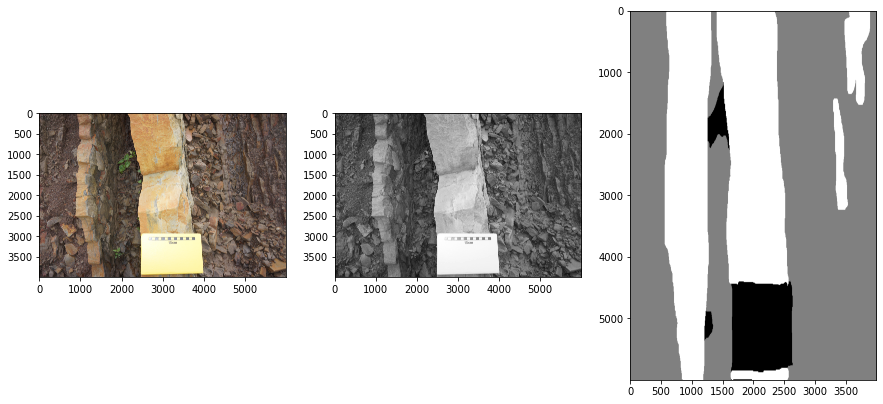

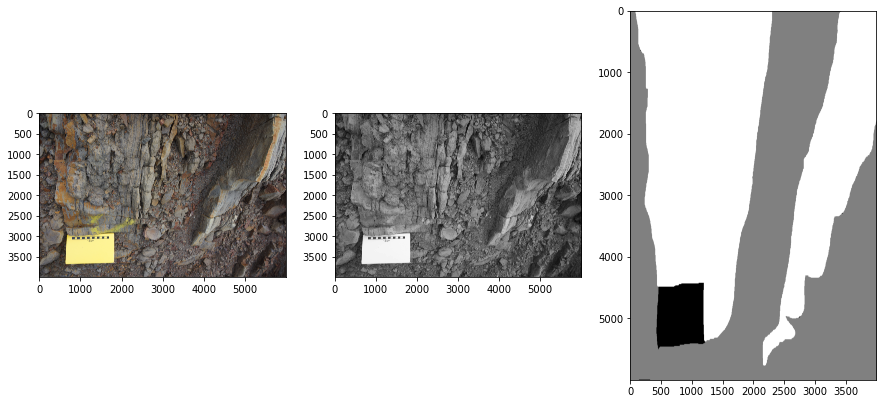

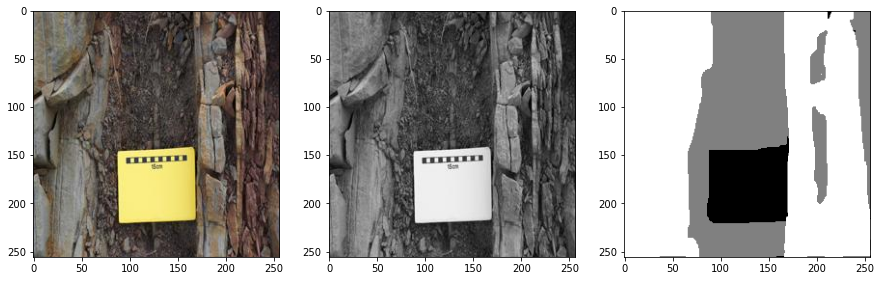

In [ ]:

seen = set()

for _ in range(5):

    while True:
        i = np.random.randint(len(image_files))
        if i not in seen:
            seen.add(i)
            break

    sample_img = cv2.imread(image_files[i])
    sample_mask = cv2.imread(mask_files[i], 0)
    print(sample_img.shape, sample_mask.shape)
    sample_mask = cv2.resize(sample_mask, sample_img.shape[:2], interpolation= cv2.INTER_AREA)

    # mask_path = "/content/drive/MyDrive/Rocks/Data_n_Masks/all_data_masks/" + "39.tiff"
    # img_path = "/content/drive/MyDrive/Rocks/Data_n_Masks/all_data_original/" + "39.jpg"
    # sample_mask = cv2.imread(mask_path, 0)
    # sample_img = cv2.imread(img_path)

    sample_img_gray = cv2.cvtColor(sample_img, cv2.COLOR_BGR2GRAY)

    fig, axes = plt.subplots(1, 3, figsize=(15, 10))
    axes[0].imshow(cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB))
    axes[1].imshow(sample_img_gray, cmap='gray')
    axes[2].imshow(sample_mask, cmap='gray')

## Pixel Length Ratio

### Functions

In [ ]:
def get_scale(img, mask):
    # get the foreground (0 corresponds to scale)
    _, scale_candidates = cv2.threshold(mask, 0, 255, cv2.THRESH_BINARY_INV)
    # find the largest contour
    cnts = cv2.findContours(scale_candidates, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    # sort the contours from left-to-righ
    (cnts, _) = contours.sort_contours(cnts)
    # get the largest contour using its area
    cont_max = max(cnts, key = cv2.contourArea)
    # find the bounding box of the contour
    x,y,w,h = cv2.boundingRect(cont_max)
    scale = img[y:y+h, x:x+w].copy()
    return scale

In [ ]:
def get_median_y1_y2(cnts):
    y1, y2 = [], []
    for c in cnts:
        box = cv2.minAreaRect(c)
        box = cv2.boxPoints(box)
        box = np.array(box, dtype="int")
        box = perspective.order_points(box)

        y1.append(box[0, 1])
        y2.append(box[2, 1])
    return stats.median(y1), stats.median(y2)

In [ ]:
def get_pixel_length_ratio(gray_img, mask, actual_width=15):
    """
    Calculates the pixel length ratio of a rectangular, yellowish scale object in a grayscale image.

    Parameters
    ----------
    gray_img : numpy.ndarray
        A grayscale image as a numpy array of shape (H, W).
    mask : numpy.ndarray
        A mask indicating the location of the scale object in the grayscale image, as a numpy array of shape (H, W).
    actual_width : int, optional
        The actual width of the scale object in centimeters. Default value is 15.

    Returns
    -------
    float
        The ratio of the width of the scale object in pixels to its actual width in centimeters.

    Notes
    -----
    This function assumes that the grayscale image and mask have the same dimensions.
    The input values are expected to be in the correct range (0-2 for mask).
    """
    '''extract the scale from the mask'''
    # crop the mask to get roi for scale
    scale = get_scale(gray_img, mask)
    '''extract the boxes from the roi'''
    # blur & threshold to only get the black boxes
    blur = cv2.GaussianBlur(scale,(5,5),0)
    _, th = cv2.threshold(blur,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    # opening operation that removes unneeded blobs
    element = cv2.getStructuringElement(cv2.MORPH_RECT,(7,7))
    morph = cv2.morphologyEx(th, cv2.MORPH_OPEN, element)
    '''locate the y coordinates of the boxes to localize the strip'''
    cnts = cv2.findContours(morph.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    (cnts, _) = contours.sort_contours(cnts)
    y1_med, y2_med = get_median_y1_y2(cnts)
    '''use the median y coordinates to get the min and max x coordinates of the strip'''
    x_coords = []
    for c in cnts:
        box = cv2.minAreaRect(c)
        box = cv2.boxPoints(box)
        box = np.array(box, dtype="int")
        box = perspective.order_points(box)
        y1, y2 = box[0, 1], box[2, 1]
        if abs(y1 - y1_med) <= 2 and abs(y2 - y2_med) <= 2:
            x_coords.append(box[0, 0])
            x_coords.append(box[1, 0])
    width = max(x_coords) - min(x_coords)
    return width / actual_width

In [ ]:
ratio = get_pixel_length_ratio(sample_img_gray, sample_mask)
ratio

7.733333333333333

### Example

In [ ]:
# # Convert BGR to HSV
# hsv = cv2.cvtColor(scale, cv2.COLOR_BGR2HSV)
# # define range of yellow color in HSV
# lower_yellow = np.array([20, 100, 100])
# upper_yellow = np.array([30, 255, 255])
# yellow_mask = cv2.inRange(hsv, lower_yellow, upper_yellow)
# # Bitwise-AND mask and original image
# res = cv2.bitwise_and(scale, scale, mask=yellow_mask)
# cv2_imshow(res)

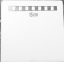

In [ ]:
img = sample_img.copy()
gray_img = sample_img_gray.copy()
mask = sample_mask.copy()

scale = get_scale(gray_img, sample_mask)
cv2_imshow(scale)

In [ ]:
# # Convert BGR to HSV
# hsv = cv2.cvtColor(scale, cv2.COLOR_BGR2HSV)
# # define range of black color in HSV
# lower_black = np.array([0, 0, 0])
# upper_black = np.array([180, 255, 30])
# black_mask = cv2.inRange(hsv, lower_black, upper_black)
# # Bitwise-AND mask and original image
# res = cv2.bitwise_and(scale, scale, mask=black_mask)
# # res = cv2.cvtColor()
# # _, res = cv2.threshold(res, 20, 255, cv2.THRESH_BINARY)
# cv2_imshow(res)

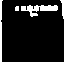

In [ ]:
blur = cv2.GaussianBlur(scale,(5,5),0)
# th = cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 5, 2)
# th = cv2.adaptiveThreshold(blur,255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 7, 2)
_, th = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
cv2_imshow(th)

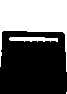

In [ ]:
h_element = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 1))

# morph = cv2.morphologyEx(th, cv2.MORPH_OPEN, h_element, iterations=1)
morph = cv2.morphologyEx(th, cv2.MORPH_CLOSE, h_element, iterations=2)
cv2_imshow(morph)

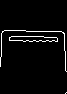

In [ ]:
edges = cv2.Canny(morph, 100, 200)
cv2_imshow(edges)

In [ ]:
cnts = cv2.findContours(edges.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
# sort the contours from left-to-right and initialize the
# 'pixels per metric' calibration variable
(cnts, _) = contours.sort_contours(cnts)
len(cnts)

3

In [ ]:
# y1_med, y2_med = get_median_y1_y2(cnts)

area_perc 0.03
extent 0.0
ratio 1.6



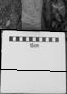


area_perc 3.11
extent 0.67
ratio 8.17



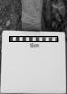


area_perc 0.0
extent 0.0
ratio 1.0



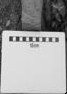

In [ ]:
for c in cnts:
    x,y,w,h = cv2.boundingRect(c)
    area = cv2.contourArea(c)
    area_perc = area / (scale.shape[0] * scale.shape[1]) * 100
    area_perc = round(area_perc, 2)
    aspect_ratio = round(float(w) / h, 2)
    rect_area = w*h
    extent = round(float(area)/rect_area, 2)
    print('area_perc', area_perc)
    print('extent', extent)
    print('ratio', aspect_ratio)
    print()
    # if area_perc < 3.5:
    #     continue
    # if extent < 0.4:
    #     continue
    # compute the rotated bounding box of the contour
    orig = scale.copy()
    box = cv2.minAreaRect(c)
    box = cv2.boxPoints(box)
    box = np.array(box, dtype="int")
    # order the points in the contour such that they appear
    # in top-left, top-right, bottom-right, and bottom-left
    # order, then draw the outline of the rotated bounding
    # box
    box = perspective.order_points(box).astype('int')
    cv2.drawContours(orig, [box], 0, (0, 255, 0), 1)
    # print(box)
    # loop over the original points and draw them
    # for (x, y) in box:
    #     cv2.circle(orig, (int(x), int(y)), 5, (0, 0, 255), -1)
    cv2_imshow(orig)
    print()

In [ ]:
# x_coords = []
# print('medians:', y1_med, y2_med)
# for c in cnts:
#     box = cv2.minAreaRect(c)
#     box = cv2.boxPoints(box)
#     box = np.array(box, dtype="int")
#     box = perspective.order_points(box)

#     y1, y2 = box[0, 1], box[2, 1]
#     if abs(y1 - y1_med) <= 2 and abs(y2 - y2_med) <= 2:
#         x_coords.append(box[0, 0])
#         x_coords.append(box[1, 0])
# width = max(x_coords) - min(x_coords)
# print(width)

In [ ]:
# coords = np.argwhere(morph == 255)
# y1 = coords[:, 0].min()
# y2 = coords[:, 0].max()
# x1 = coords[:, 0].min()
# x2 = coords[:, 1].max()
# width = x2 - x1
# print(width / 15)

## Actual Width Calculation

### Function

In [ ]:
def group_width(group):
    '''Get the width of a flat line'''
    return group[:, 0].max() - group[:, 0].min()

def keep_spaced_elements(unsorted_list, threshold):
    '''
    Takes the unsorted list corresponding to the width of each flat line
    Returns a new list such that for every element i, j in the new list,
        the difference abs(i - j) >= threshold
    The indices of the elements to keep in the unsorted list are returned
    '''
    n = len(unsorted_list)
    sorted_list = sorted(range(n), key=lambda i: unsorted_list[i])
    indices = [sorted_list[0]]
    for i in range(1, n):
        if abs(unsorted_list[sorted_list[i]] - unsorted_list[indices[-1]]) >= threshold:
            indices.append(sorted_list[i])
    return indices


def keep_varying_lines(flat_lines, line_sim_thresh):
    '''
    Take the flat_lines and line similarity threshold as input
    Return all the lines whose difference is >= line_sim_thresh
    '''
    widths = [group_width(g) for g in flat_lines]
    indices_keep = keep_spaced_elements(widths, threshold=line_sim_thresh)
    # print('widths', widths, 'idx', indices_keep)
    flat_lines_filtered = [flat_lines[i] for i in indices_keep]
    widths = sorted([group_width(g) for g in flat_lines_filtered])
    # print('widths_new', widths)
    return flat_lines_filtered
        
def group_points_by_y(points, y_range=2):
    # sort the points by y-coordinate
    points = np.squeeze(points)
    points = points[np.argsort(points[:, 1])]
    
    groups = []
    group = []
    for i in range(len(points)):
        if len(group) == 0:
            group.append(points[i].tolist())
        else:
            # check if the y-coordinate of the current point is within a range of y_range
            if abs(points[i][1] - group[-1][1]) <= y_range:
                group.append(points[i].tolist())
            else:
                groups.append(group)
                group = [points[i].tolist()]
    
    if len(group) > 0:
        groups.append(group)
    
    return groups


def find_flat_lines(contour, img, width_threshold=10, line_sim_thresh=5, ratio=1):
    # group points by their y-coordinates
    groups = group_points_by_y(contour)
    
    # initialize the list of flat lines
    flat_lines = []
    
    # iterate over each group of points
    for i in range(len(groups)):
        group = np.array(groups[i])
        
        # compute the maximum and minimum x-coordinates for the group
        x_min = np.min(group[:, 0])
        x_max = np.max(group[:, 0])
        
        # compute the width of the group
        width = x_max - x_min
        
        # if the width is less than the threshold, merge the group with the previous one
        if width < width_threshold and i > 0:
            prev_group = np.array(groups[i-1])
            merged_group = np.concatenate((prev_group, group))
            groups[i-1] = merged_group.tolist()
        else:
            flat_lines.append(group)

    # remove lines with similar widths
    flat_lines = keep_varying_lines(flat_lines, line_sim_thresh)
    # reduce_list_inplace(flat_lines, keep_varying_lines, line_sim_thresh=line_sim_thresh)
        
    # the number of flat lines is the number of groups
    num_flat_lines = len(flat_lines)
    
    # add arrows to show the flat lines
    for i in range(num_flat_lines):
        line = np.array(flat_lines[i])
        x_min = np.min(line[:, 0]).astype('uint8')
        x_max = np.max(line[:, 0]).astype('uint8')
        y = np.mean(line[:, 1]).astype('uint8')
        cv2.arrowedLine(img, (x_min, y), (x_max, y), (0, 255, 0), 1)
        width = (x_max - x_min) / ratio
        text = f'{width}cm'
        if y < 10:
            yloc = int(y) + 10
        else:
            yloc = int(y) - 10
        cv2.putText(img, text, (x_min, yloc), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 0, 255), 1)
    
    return flat_lines, num_flat_lines, img

In [ ]:
def draw_widths(img, mask, ratio=1, morph1=False, morph2=False,
                width_threshold=3, line_sim_thresh=6):
    # threshold the mudstone
    thresh = np.where(sample_mask == 2, 255, 0).astype(np.uint8)
    
    # optionally, perform some morphology
    morph = thresh.copy()
    big_element = cv2.getStructuringElement(cv2.MORPH_RECT,(7,7))
    small_element = cv2.getStructuringElement(cv2.MORPH_RECT,(3,3))
    if morph1:
        # remove small rectangles
        morph = cv2.morphologyEx(morph, cv2.MORPH_OPEN, big_element, iterations=1)
        # restore connections
        morph = cv2.morphologyEx(morph, cv2.MORPH_CLOSE, big_element, iterations=1)
        if morph2:
            # remove extraneous connections
            morph = cv2.morphologyEx(morph, cv2.MORPH_OPEN, small_element, iterations=1)
    '''contour analysis'''
    # find the largest contour
    cnts = cv2.findContours(morph, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    # sort the contours from left-to-right
    (cnts, _) = contours.sort_contours(cnts)

    for c in cnts:
        # copy the original image to prevent editing it
        orig = img.copy()
        h, w = orig.shape[:2]
        # minimum contour area should be >= 2% of image
        area = cv2.contourArea(c)
        perc = area / (h * w) * 100
        if perc < 2:
            continue
        cv2.drawContours(orig, [c], 0, (0,0,255), 1)
        # find the widths
        flat_lines, num_flat_lines, orig = find_flat_lines(c, orig, 
                                                           width_threshold=width_threshold,
                                                           line_sim_thresh=line_sim_thresh,
                                                           ratio=ratio)
        # print(num_flat_lines)
        cv2_imshow(orig)
        print()

### Example

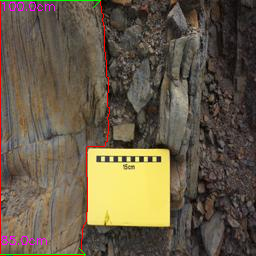

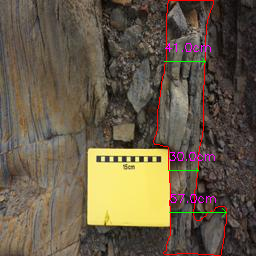

In [ ]:
draw_widths(sample_img, sample_mask, ratio=1, width_threshold=20, line_sim_thresh=10)

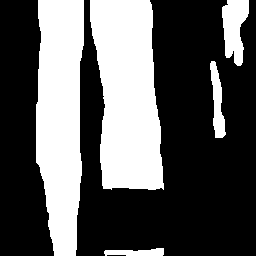

In [ ]:
thresh = np.where(sample_mask == 2, 255, 0).astype(np.uint8)
cv2_imshow(thresh)

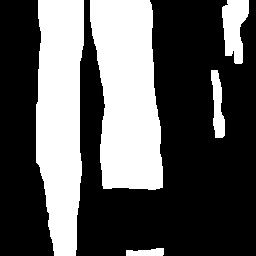

In [ ]:
big_element = cv2.getStructuringElement(cv2.MORPH_RECT,(7,7))
small_element = cv2.getStructuringElement(cv2.MORPH_RECT,(3,3))

morph = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, big_element, iterations=1)
# morph = cv2.morphologyEx(morph, cv2.MORPH_CLOSE, big_element, iterations=1)
# morph = cv2.morphologyEx(morph, cv2.MORPH_OPEN, small_element, iterations=1)
cv2_imshow(morph)

#### Contours

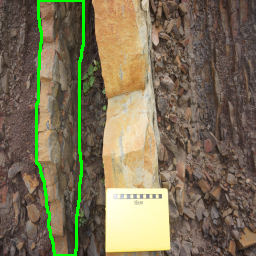

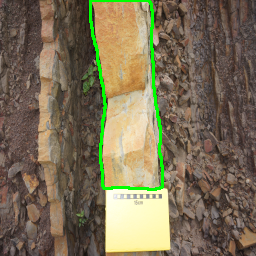

In [ ]:
# find the largest contour
cnts = cv2.findContours(morph, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
# sort the contours from left-to-right
(cnts, _) = contours.sort_contours(cnts)

for c in cnts:
    orig = sample_img.copy()
    h,w = orig.shape[:2]
    area = cv2.contourArea(c)
    orig = sample_img.copy()
    h, w = orig.shape[:2]
    perc = area / (h * w) * 100
    if perc < 2:
        continue
    cv2.drawContours(orig, [c], 0, (0,255,0), 2)
    cv2_imshow(orig)
    print()

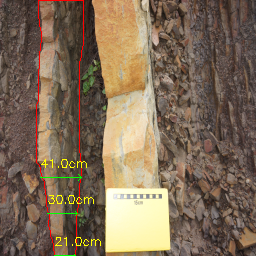

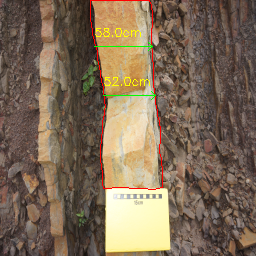

In [ ]:
for c in cnts:
    orig = sample_img.copy()
    h, w = orig.shape[:2]
    area = cv2.contourArea(c)
    perc = area / (h * w) * 100
    if perc < 2:
        continue
    cv2.drawContours(orig, [c], 0, (0,0,255), 1)
    flat_lines, num_flat_lines, orig = find_flat_lines(c, orig, width_threshold=3, line_sim_thresh=6)
    # print(num_flat_lines)
    cv2_imshow(orig)
    print()
    # break

#### Connected Components

In [ ]:
def draw_widths_old(mask, img, ratio, erosion_it=2):
    thresh = np.where(sample_mask == 2, 255, 0).astype(np.uint8)

    morph = cv2.erode(thresh, None, iterations=erosion_it)
    morph = cv2.dilate(morph, None, iterations=1)

    output = cv2.connectedComponentsWithStats(morph, 8, cv2.CV_32S)
    (numLabels, labels, stats, centroids) = output

    # loop over the number of unique connected component labels
    for i in range(numLabels):
        # if this is the first component then we examine the
        # *background* (typically we would just ignore this
        # component in our loop)
        if i == 0:
            text = "skipping component {}/{} (background)".format(
                i + 1, numLabels)
            continue
        # otherwise, we are examining an actual connected component
        else:
            text = "examining component {}/{}".format( i + 1, numLabels)
        # print a status message update for the current connected
        # component
        print("[INFO] {}".format(text))
        # extract the connected component statistics and centroid for
        # the current label
        x = stats[i, cv2.CC_STAT_LEFT]
        y = stats[i, cv2.CC_STAT_TOP]
        w = stats[i, cv2.CC_STAT_WIDTH]
        h = stats[i, cv2.CC_STAT_HEIGHT]
        print('width:', w)
        area = stats[i, cv2.CC_STAT_AREA]
        (cX, cY) = centroids[i]
        output = sample_img.copy()
        cv2.rectangle(output, (x, y), (x + w, y + h), (0, 255, 0), 3)
        actual_length = (w / ratio).round(1)
        cv2.arrowedLine(output, (x, int(cY)), (x + w, int(cY)), (0, 0, 255), 1)
        text = f'{actual_length}cm'
        cv2.putText(output, text, (x, int(cY)-10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 1)
        # cv2.circle(output, (int(cX), int(cY)), 4, (0, 0, 255), -1)
        componentMask = (labels == i).astype("uint8") * 255
        cv2_imshow(output)
        cv2_imshow(componentMask)
        print()

In [ ]:
output = cv2.connectedComponentsWithStats(morph, 8, cv2.CV_32S)
(numLabels, labels, stats, centroids) = output

# loop over the number of unique connected component labels
for i in range(numLabels):
    # if this is the first component then we examine the
    # *background* (typically we would just ignore this
    # component in our loop)
    if i == 0:
        text = "skipping component {}/{} (background)".format(
            i + 1, numLabels)
        continue
    # otherwise, we are examining an actual connected component
    else:
        text = "examining component {}/{}".format( i + 1, numLabels)
    # print a status message update for the current connected
    # component
    print("[INFO] {}".format(text))
    # extract the connected component statistics and centroid for
    # the current label
    x = stats[i, cv2.CC_STAT_LEFT]
    y = stats[i, cv2.CC_STAT_TOP]
    w = stats[i, cv2.CC_STAT_WIDTH]
    h = stats[i, cv2.CC_STAT_HEIGHT]
    print('width:', w)
    area = stats[i, cv2.CC_STAT_AREA]
    (cX, cY) = centroids[i]
    output = sample_img.copy()
    cv2.rectangle(output, (x, y), (x + w, y + h), (0, 255, 0), 3)
    actual_length = (w / ratio).round(1)
    cv2.arrowedLine(output, (x, int(cY)), (x + w, int(cY)), (0, 0, 255), 1)
    text = f'{actual_length}cm'
    cv2.putText(output, text, (x, int(cY)-10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 1)
    # cv2.circle(output, (int(cX), int(cY)), 4, (0, 0, 255), -1)
    componentMask = (labels == i).astype("uint8") * 255
    cv2_imshow(output)
    cv2_imshow(componentMask)
    print()
    print()